In [ ]:
import pandas as pd
import numpy as np

# Generate dates
dates = pd.date_range(start="2018-06-01", end="2020-05-31")
num_records = len(dates)

# Create the synthetic data
np.random.seed(42)
data = {
    'date': np.tile(dates, 9),
    'age_group': np.repeat(['young', 'middle-age', 'aging'], num_records * 3),
    'purpose': np.tile(np.repeat(['leisure', 'middle-class', 'business'], num_records), 3),
    'flights': np.random.poisson(lam=40, size=num_records * 9).astype(int) # Ensure integer values
}

df = pd.DataFrame(data)

In [ ]:
# Overview of Dataframe
df

,date,age_group,purpose,flights
0,2018-06-01,young,leisure,38
1,2018-06-02,young,leisure,44
2,2018-06-03,young,leisure,33
3,2018-06-04,young,leisure,42
4,2018-06-05,young,leisure,47
...,...,...,...,...
6574,2020-05-27,aging,business,37
6575,2020-05-28,aging,business,38
6576,2020-05-29,aging,business,45
6577,2020-05-30,aging,business,51


In [ ]:
# Define segments
df['segment'] = (
    df['age_group'].map({
        'young': 'A1',
        'middle-age': 'A4',
        'aging': 'A7'
    }) + ' ' +
    df['purpose'].map({
        'leisure': '1',
        'middle-class': '2',
        'business': '3'
    })
)

# Map segments to correct labels
segment_map = {
    'A1 1': 'A1: young & leisure',
    'A1 2': 'A2: young & middle-class',
    'A1 3': 'A3: young & business',
    'A4 1': 'A4: middle-age & leisure',
    'A4 2': 'A5: middle-age & middle-class',
    'A4 3': 'A6: middle-age & business',
    'A7 1': 'A7: aging & leisure',
    'A7 2': 'A8: aging & middle-class',
    'A7 3': 'A9: aging & business',
}

df['segment'] = df['segment'].map(segment_map)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Aggregate data by date and segment
ts_df = df.groupby(['date', 'segment']).agg({'flights': 'sum'}).unstack(fill_value=0)
ts_df.columns = ts_df.columns.get_level_values(1)
all_dates = pd.date_range(start="2018-06-01", end="2020-05-31")
ts_df = ts_df.reindex(all_dates, fill_value=0)

# Define the parameters for each segment (Based on the Information in Paper)
segment_params = {
    'A1: young & leisure': {'order': (2, 1, 3), 'seasonal_order': (5, 1, 1, 12)},
    'A2: young & middle-class': {'order': (5, 1, 1), 'seasonal_order': (4, 1, 2, 12)},
    'A3: young & business': {'order': (1, 1, 1), 'seasonal_order': (4, 1, 2, 12)},
    'A4: middle-age & leisure': {'order': (0, 1, 1), 'seasonal_order': (0, 1, 2, 12)},
    'A5: middle-age & middle-class': {'order': (4, 1, 1), 'seasonal_order': (3, 1, 2, 12)},
    'A6: middle-age & business': {'order': (4, 1, 3), 'seasonal_order': (5, 1, 1, 12)},
    'A7: aging & leisure': {'order': (0, 1, 1), 'seasonal_order': (3, 1, 1, 12)},
    'A8: aging & middle-class': {'order': (0, 1, 1), 'seasonal_order': (5, 1, 2, 12)},
    'A9: aging & business': {'order': (3, 1, 3), 'seasonal_order': (5, 1, 1, 12)}
}

# Dictionary to store forecasts for each scenario and segment
forecasts = {'usual': {}, 'pandemic': {}}

for segment, params in segment_params.items():
    # Fit SARIMA model for usual scenario
    model_usual = SARIMAX(ts_df[segment], order=params['order'], seasonal_order=params['seasonal_order'])
    results_usual = model_usual.fit()
    forecast_usual = results_usual.forecast(steps=90)
    forecasts['usual'][segment] = forecast_usual

    # Apply pandemic scenario: generate random multiplier (Flight Availability) between 0 and 1
    random_multiplier = np.random.rand()  # Generate random number between 0 and 1
    forecast_pandemic = forecast_usual * random_multiplier
    forecasts['pandemic'][segment] = forecast_pandemic

# Print forecasts for all segments and scenarios
for scenario, segment_forecasts in forecasts.items():
    print(f"Forecasts for scenario: {scenario}")
    for segment, forecast in segment_forecasts.items():
        print(f"Forecast for {segment}:")
        print(forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: Use

Forecasts for scenario: usual
Forecast for A1: young & leisure:
2020-06-01    42.697521
2020-06-02    37.946641
2020-06-03    39.634792
2020-06-04    39.569271
2020-06-05    41.102658
                ...    
2020-08-25    39.075175
2020-08-26    40.044778
2020-08-27    39.722732
2020-08-28    40.402385
2020-08-29    39.742231
Freq: D, Name: predicted_mean, Length: 90, dtype: float64
Forecast for A2: young & middle-class:
2020-06-01    40.913721
2020-06-02    39.960528
2020-06-03    41.599468
2020-06-04    41.487944
2020-06-05    40.021224
                ...    
2020-08-25    40.092516
2020-08-26    39.959919
2020-08-27    40.548421
2020-08-28    40.878546
2020-08-29    38.730626
Freq: D, Name: predicted_mean, Length: 90, dtype: float64
Forecast for A3: young & business:
2020-06-01    39.515850
2020-06-02    40.652311
2020-06-03    39.654537
2020-06-04    39.350902
2020-06-05    40.201166
                ...    
2020-08-25    40.668081
2020-08-26    40.045502
2020-08-27    39.887744
20

In [ ]:
# Dictionary to store real numbers of flights for each segment
real_flights = {}

# Generate synthetic real numbers of flights based on usual scenario forecasts
for segment, forecast in forecasts['usual'].items():
    # Generate noise with a negative mean
    noise = np.random.normal(loc=-35, scale=2, size=len(forecast))  # Mean of -25, standard deviation of 10
    # Subtract the noise from the forecast to get real data
    real_data = forecast + noise

    real_data[real_data < 0] = 0

    # Round the real data to the nearest integer
    real_data = np.round(real_data).astype(int)
    # Store the real data
    real_flights[segment] = real_data


In [ ]:
from google.colab import files

# Assuming forecasts, real_flights, and ts_df are already defined
impact_data = {}

# Adjust the date range to match the length of the forecasts
all_dates = pd.date_range(start="2020-06-01", periods=90)

# Ensure all forecast arrays are of the same length as the date range
def validate_length(arr, target_len, name):
    if len(arr) != target_len:
        raise ValueError(f"Length of {name} ({len(arr)}) does not match target length ({target_len})")

for segment in ts_df.columns:
    validate_length(forecasts['usual'][segment], len(all_dates), f"forecasts['usual'][{segment}]")
    validate_length(forecasts['pandemic'][segment], len(all_dates), f"forecasts['pandemic'][{segment}]")
    validate_length(real_flights[segment], len(all_dates), f"real_flights[{segment}]")

# Calculate twofold impact and impacts of each force for each segment
for segment in ts_df.columns:
    # Calculate twofold impact of COVID-19
    twofold_impact = (forecasts['usual'][segment] - real_flights[segment]) / forecasts['usual'][segment]

    # Calculate impact associated with supply restriction (S.R.I.)
    supply_restriction_impact = (forecasts['usual'][segment] - forecasts['pandemic'][segment]) / (forecasts['usual'][segment] - real_flights[segment])

    # Calculate impact associated with demand depression (D.D.I.)
    demand_depression_impact = (forecasts['pandemic'][segment] - real_flights[segment]) / (forecasts['usual'][segment] - real_flights[segment])

    # Compile the data into a DataFrame
    segment_data = pd.DataFrame({
        'Date of Flight': all_dates,
        'Usual Scenario Value': forecasts['usual'][segment],
        'Pandemic Scenario Value': forecasts['pandemic'][segment],
        'Real Data Value': real_flights[segment],
        'Twofold Impact': twofold_impact,
        'Supply Restriction Impact': supply_restriction_impact,
        'Demand Depression Impact': demand_depression_impact
    })

    # Save the DataFrame to a CSV file
    filename = f'{segment}_impact_data.csv'
    segment_data.to_csv(filename, index=False)

    # Download the CSV file
    files.download(filename)

    # Store impact data in a dictionary for further use
    impact_data[segment] = segment_data

# Print twofold impact and impacts of each force for each segment
for segment, impacts in impact_data.items():
    print(f"Impact data for segment: {segment}")
    print(impacts.head())  # Print the first few rows to verify
    print()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Impact data for segment: A1: young & leisure
           Date of Flight  Usual Scenario Value  Pandemic Scenario Value  \
2020-06-01     2020-06-01             42.697521                16.790649   
2020-06-02     2020-06-02             37.946641                14.922382   
2020-06-03     2020-06-03             39.634792                15.586242   
2020-06-04     2020-06-04             39.569271                15.560476   
2020-06-05     2020-06-05             41.102658                16.163475   

            Real Data Value  Twofold Impact  Supply Restriction Impact  \
2020-06-01                8        0.812635                   0.746649   
2020-06-02                4        0.894589                   0.678249   
2020-06-03                5        0.873848                   0.694347   
2020-06-04                8        0.797823                   0.760512   
2020-06-05                9        0.781036                   0.776857   

            Demand Depression Impact  
2020-06-01    

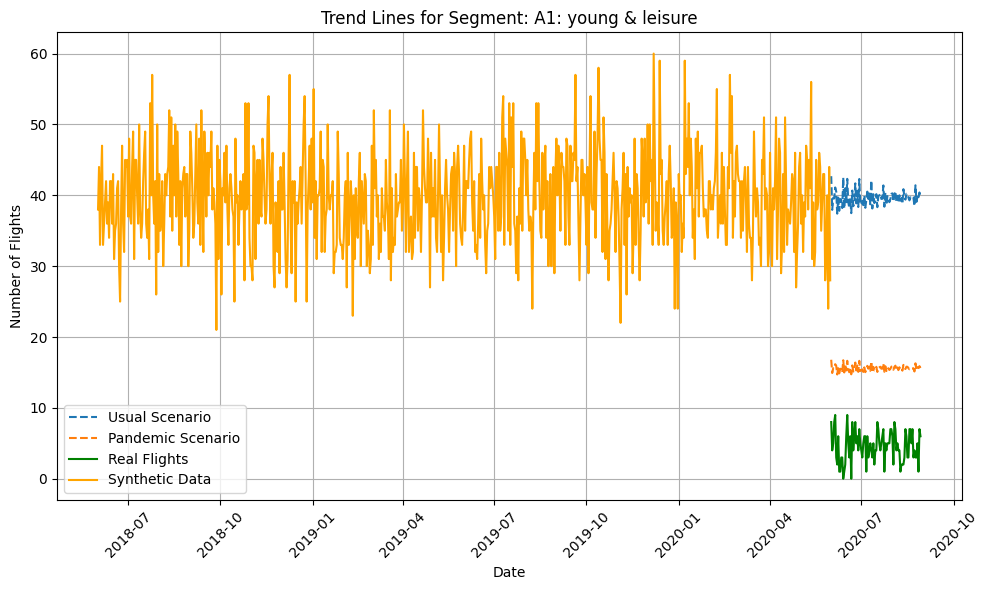

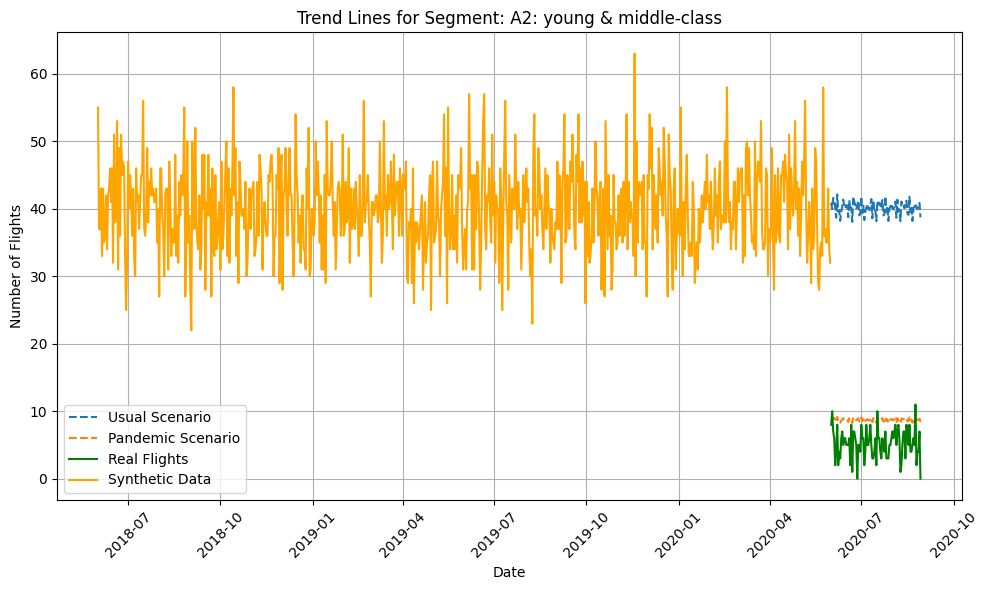

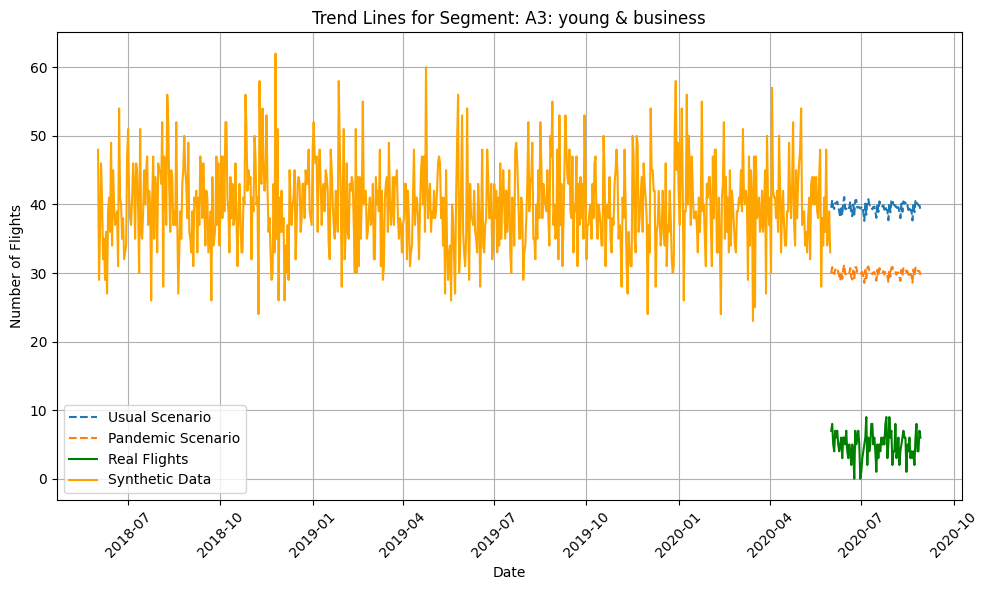

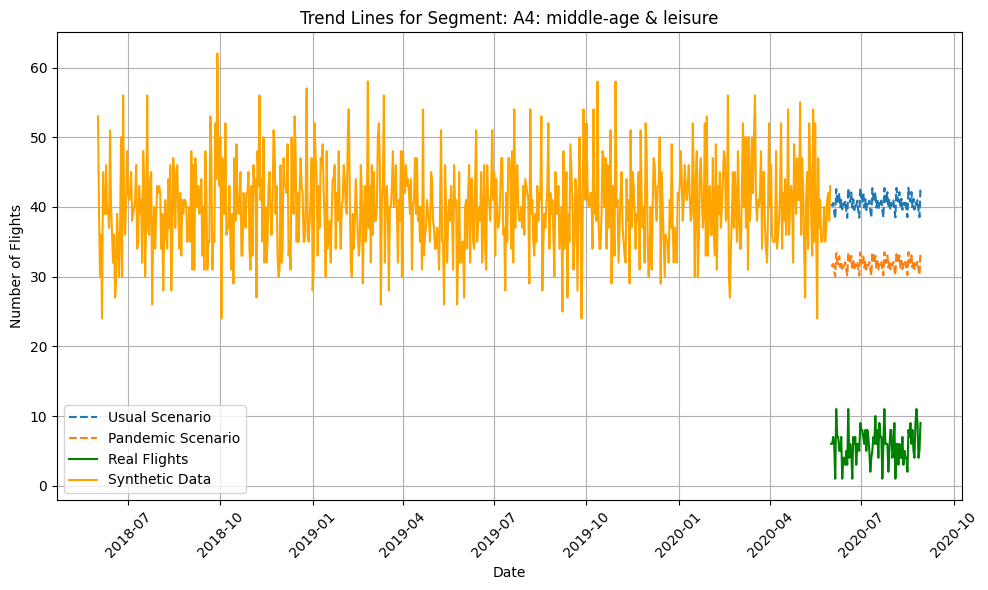

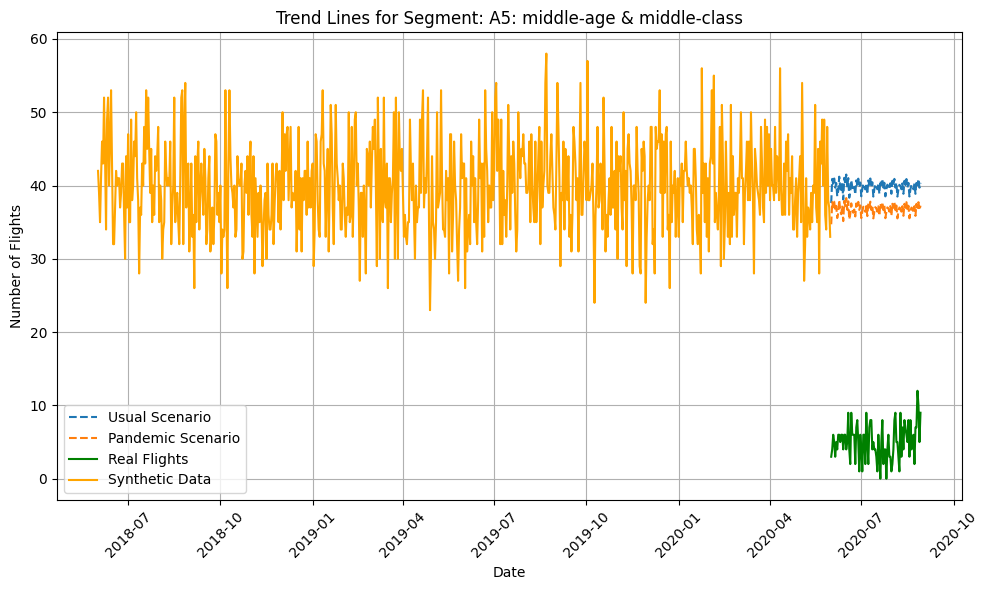

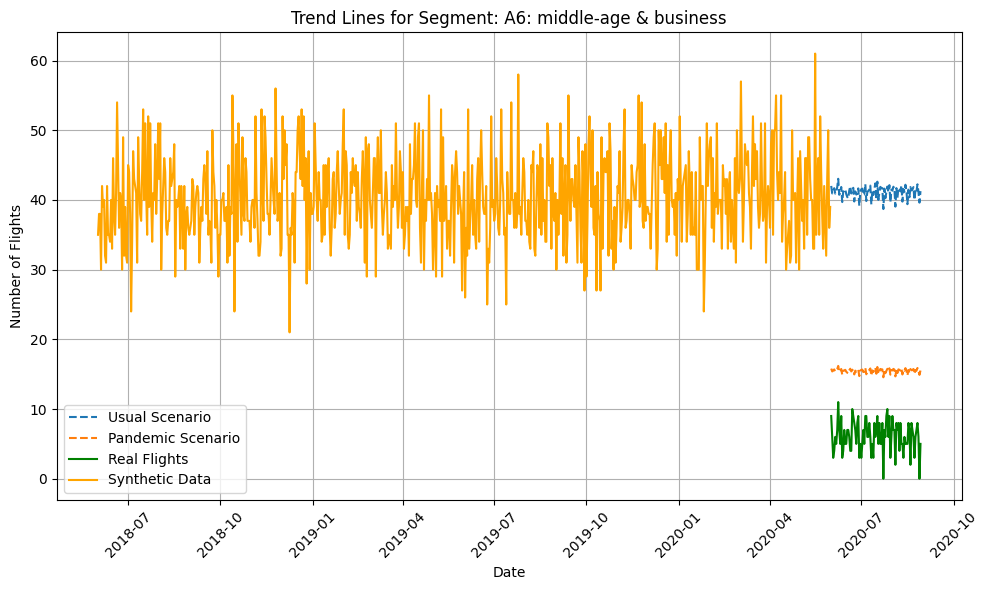

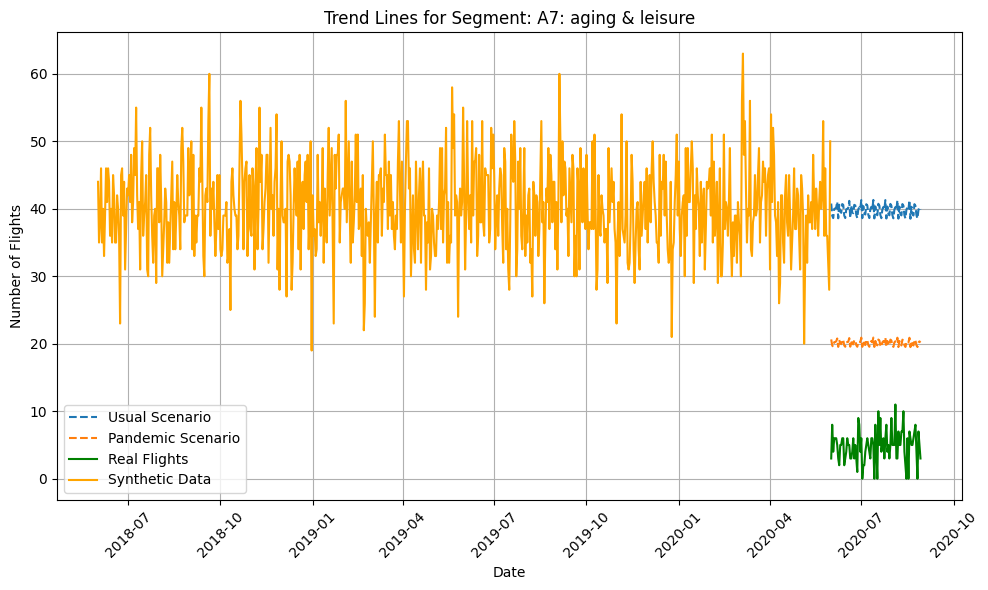

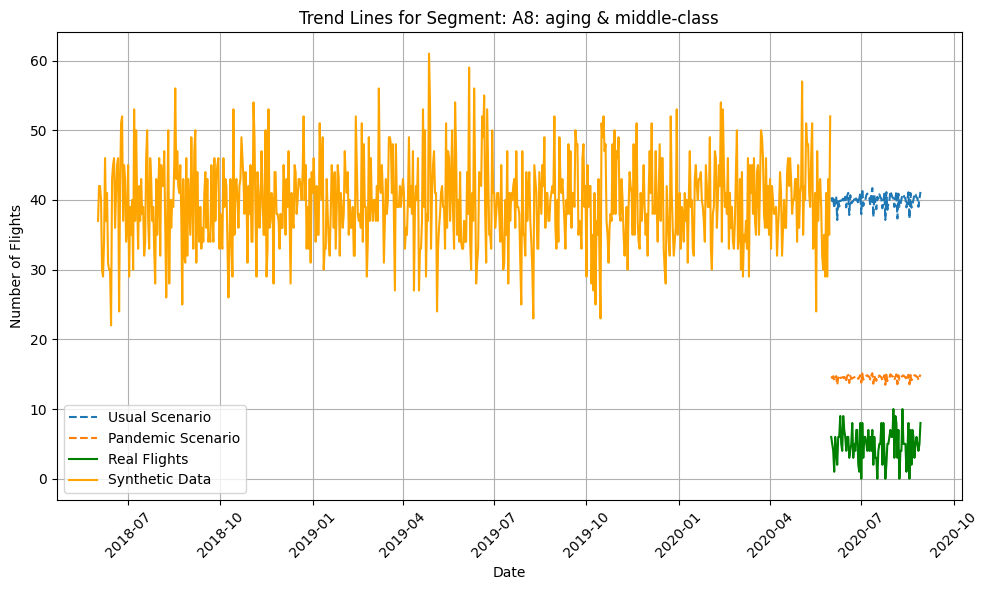

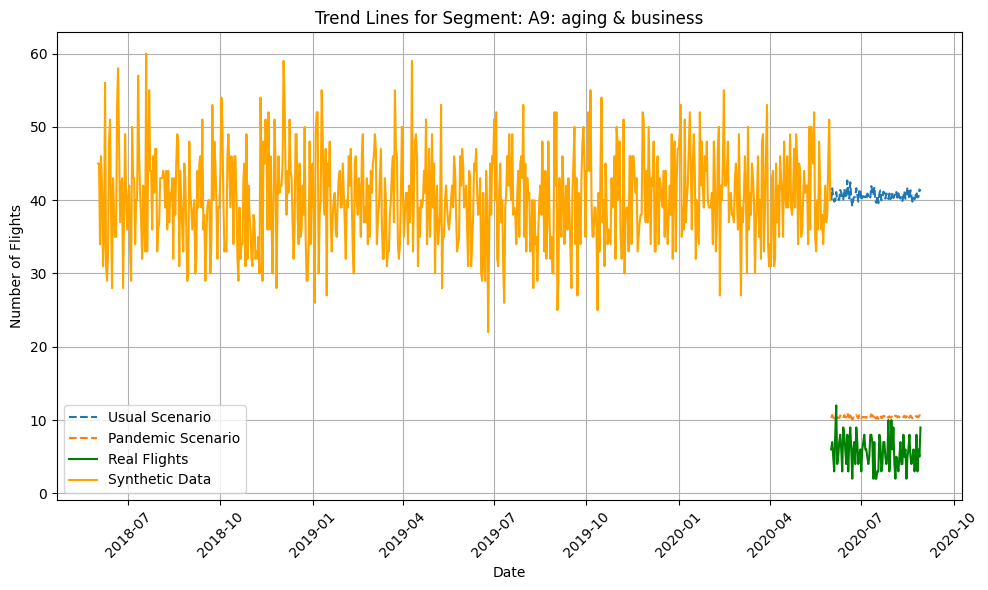

In [ ]:
import matplotlib.pyplot as plt

# Plotting trend lines for each segment
for i, (segment, impacts) in enumerate(impact_data.items()):
    plt.figure(figsize=(10, 6))
    plt.plot(impacts['Date of Flight'], impacts['Usual Scenario Value'], label='Usual Scenario', linestyle='--')
    plt.plot(impacts['Date of Flight'], impacts['Pandemic Scenario Value'], label='Pandemic Scenario', linestyle='--')

    # Plotting Real Data Value
    plt.plot(impacts['Date of Flight'], impacts['Real Data Value'], label='Real Flights', color='green')

    # Plotting synthetic data
    segment_synthetic = ts_df[segment]
    plt.plot(segment_synthetic.index, segment_synthetic, label='Synthetic Data', color='orange')

    plt.title(f'Trend Lines for Segment: {segment}')
    plt.xlabel('Date')
    plt.ylabel('Number of Flights')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
